In [2]:
from pathlib import Path
import numpy as np
import datetime
import json
import os
import pandas as pd
import rasterio
import skimage.io as skio
from PIL import Image

from cropmask.misc import *

from cropmask import detectron2_reclass # fair amount of stuff goes on in here to make detectron work for this project.
from detectron2.data.datasets import register_coco_instances, load_coco_json

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import cv2
import random
from skimage.io import imshow, imread
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt
# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor, launch
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from cropmask.misc import max_normalize, percentile_rescale
from cropmask.detectron2_cropmask_cfg import cfg
from cropmask import detectron2_reclass # fair amount of stuff goes on in here to make detectron work for this project.

import shutil
import json

AssertionError: Config file '/home/ryan/CropMask_RCNN/base_config.yaml' does not exist!

Loading Trained FCIS model and results on Nebraska Dataset

In [ ]:
"/datadrive/denmark-data/output/resnet_v1_101_coco_fcis_end2end_ohem-nebraska/train-nebraska/resnet_v1_101_coco_fcis_end2end_ohem-nebraska_2020-04-05-23-58.log"

In [ ]:
import json

with open("/datadrive/denmark-data/output/resnet_v1_101_coco_fcis_end2end_ohem-nebraska/val-nebraska/results/detections_val-nebraska_results.json", "r") as f:
    results = json.load(f)

In [ ]:
import pickle as pkl
with open("/datadrive/denmark-data/output/resnet_v1_101_coco_fcis_end2end_ohem-nebraska/val-nebraska/results/detections_val-nebraska_results.pkl", "rb") as f:
    results_pkl = pkl.load(f)

### Printing Truth Labels and Images

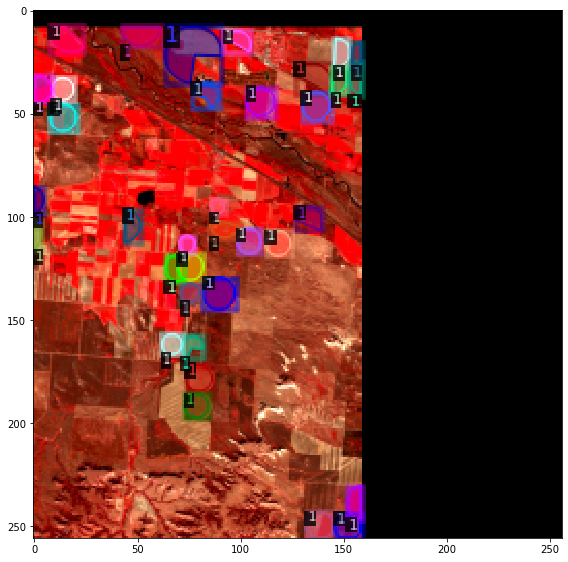

In [9]:
for d in random.sample(train_json, 1):
    if len(d['annotations']) > 0:
        img = imread(d["file_name"])
        img = img[:, :, ::-1]
#         normalized = max_norm_channels(np.where(img < 0, 0, img))
#         rescaled = rescale_intensity(normalized, out_range=(0,255))
#         masked = np.where(rescaled==0, np.nan, rescaled)
        visualizer = Visualizer(img, metadata={}, scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        plt.figure(figsize = (8,16))
        imshow(vis.get_image())

# Model Inspection

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0002399.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
for d in random.sample(train_json, 1):    
    im = imread(d["file_name"])
    outputs = predictor(im)
    vis_im = make_vis_im(im)
    visualizer_preds = Visualizer(vis_im,
                   scale=1, 
                   metadata= {}   # remove the colors of unsegmented pixels
    )
    visualizer_labels = Visualizer(vis_im,
                   scale=1, 
                   metadata= {}   # remove the colors of unsegmented pixels
    )
    v = visualizer_preds.draw_instance_predictions(outputs["instances"].to("cpu"))
    labels = visualizer_labels.draw_dataset_dict(d)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,16))
    imshow(v.get_image(), ax=ax[0])
    imshow(labels.get_image(), ax=ax[1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("test", cfg, False, output_dir="/datadrive/evaluator_output/")
test_loader = build_detection_test_loader(cfg, "test")

In [ ]:
inference_on_dataset(predictor.model, test_loader, evaluator)
# another equivalent way is to use trainer.test